In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
from datetime import timedelta
import datetime

# Please read, my idea was to classify the data into three cateogries: "UP", "DOWN", "NEUTRAL"
# UP - the price of the stock is up MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# DOWN - the price of the stock is down MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# NEUTRAL - the price of stock is did not rise or fall past the MINIMUM_GAIN threshhold
#
# EXAMPLE: LOOK_AHEAD_DAYS = 30, MINIMUM_GAIN = .05 (5%). If stock is up over 5% ore more after 30 days, 
# we mark it as 'UP'. If the stock is down 5% or more after 30 days, we mark it as 'DOWN'. If the stock
# is neither up nor down 5%, then we mark it as 'NEUTRAL'

# MINIMUM_GAIN = .05 #minimal gain to be considered up or down for classification, UNUSED NOW

LOOK_BACK_DAYS = 30 #number of days into the past we would like to take into account
LOOK_AHEAD_DAYS = 1 #number of days into the future we are trying to predict

class Utilities:

    @staticmethod
    def getData(ticker, start_date, end_date):
        try:
            stock_data = data.DataReader(ticker,
                                         'yahoo',
                                         start_date,
                                         end_date)
            return stock_data
        except RemoteDataError:
            print('No data found for {t}'.format(t=ticker))
#just get the btc price points from the past year
start_date = datetime.datetime.now() - timedelta(365)
end_date = datetime.datetime.now() - timedelta(1)
btc_df = Utilities.getData('BTC-USD', str(start_date.strftime('%Y-%m-%d')), str(end_date.strftime('%Y-%m-%d')))
btc_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-13,10889.556641,10028.135742,10889.487305,10051.704102,1.999084e+10,10051.704102
2019-08-14,10437.411133,9675.316406,10038.421875,10311.545898,2.289912e+10,10311.545898
2019-08-15,10524.349609,9855.478516,10319.419922,10374.338867,2.022821e+10,10374.338867
2019-08-16,10452.625000,10086.698242,10358.722656,10231.744141,1.377804e+10,10231.744141
2019-08-17,10487.070312,10119.094727,10233.005859,10345.810547,1.299981e+10,10345.810547
...,...,...,...,...,...,...
2020-08-08,11806.056641,11548.784180,11737.325195,11675.739258,1.748961e+10,11675.739258
2020-08-09,12045.140625,11662.256836,11662.256836,11878.111328,2.611411e+10,11878.111328
2020-08-10,11932.710938,11195.708984,11881.647461,11410.525391,2.703978e+10,11410.525391


In [3]:
def createLookBackCols():
    for i in range(LOOK_BACK_DAYS):
        num_rows= btc_df.shape[0]
        num_cols= btc_df.shape[1]
        btc_df.insert(loc = num_cols, column = 'High_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Low_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Open_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Volume_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Adj Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        
createLookBackCols() #create additional look back columns
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
    if (current_date - start_date).days >= LOOK_BACK_DAYS - 1:
        for i in range(LOOK_BACK_DAYS):
            index = i + 1
            look_back_date = current_date - timedelta(days=index)
            
            while True: #we need to keep subtracting days to the look_back_date because there is no index for that day
                if look_back_date in btc_df.index:
                    break
                look_back_date = look_back_date - timedelta(days=1)
            
            btc_df.at[pd.Timestamp(current_date), 'High_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'High']
            btc_df.at[pd.Timestamp(current_date), 'Low_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Low']
            btc_df.at[pd.Timestamp(current_date), 'Open_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Open']
            btc_df.at[pd.Timestamp(current_date), 'Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Close']
            btc_df.at[pd.Timestamp(current_date), 'Volume_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Volume']
            btc_df.at[pd.Timestamp(current_date), 'Adj Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Adj Close']

btc_df = btc_df[btc_df.High_Past_1 != 'N/A']
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Close_Past_29,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-13,10422.133789,10291.694336,10345.403320,10358.048828,1.346871e+10,10358.048828,10360.5,1.41099e+10,10360.5,10415.4,...,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4
2019-09-14,10387.035156,10313.092773,10356.465820,10347.712891,1.204343e+10,10347.712891,10358,1.34687e+10,10358,10345.4,...,10231.7,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3
2019-09-15,10386.867188,10189.744141,10347.222656,10276.793945,1.516017e+10,10276.793945,10347.7,1.20434e+10,10347.7,10356.5,...,10345.8,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6
2019-09-16,10296.771484,10199.739258,10281.513672,10241.272461,1.530460e+10,10241.272461,10276.8,1.51602e+10,10276.8,10347.2,...,10916.1,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1
2019-09-17,10275.928711,10191.469727,10247.795898,10198.248047,1.616927e+10,10198.248047,10241.3,1.53046e+10,10241.3,10281.5,...,10763.2,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-08,11806.056641,11548.784180,11737.325195,11675.739258,1.748961e+10,11675.739258,11754,1.75721e+10,11754,11604.6,...,9240.35,9277.51,9199.49,9293.53,9278.81,1.686e+10,9278.81,9273.36,9118,9287.47
2020-08-09,12045.140625,11662.256836,11662.256836,11878.111328,2.611411e+10,11878.111328,11675.7,1.74896e+10,11675.7,11737.3,...,9276.5,9241.05,9197.45,9319.42,9240.35,1.32499e+10,9240.35,9277.51,9199.49,9293.53
2020-08-10,11932.710938,11195.708984,11881.647461,11410.525391,2.703978e+10,11410.525391,11878.1,2.61141e+10,11878.1,11662.3,...,9243.61,9277.21,9224.29,9306.41,9276.5,1.44524e+10,9276.5,9241.05,9197.45,9319.42


In [4]:
btc_df = btc_df.assign(MonthTrend=lambda x: "N/A") #introduce new column that will be the trend we are predicting
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

#Populate the classification column MonthTrend
for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
   
    if (end_date - current_date).days > LOOK_AHEAD_DAYS:
        look_ahead_date = current_date + timedelta(days=LOOK_AHEAD_DAYS)
        
        while True: #we need to keep adding days to the look_ahead_date because there is no index for that day
            if look_ahead_date in btc_df.index:
                break
            look_ahead_date = look_ahead_date + timedelta(days=1)
        
        #Here we check if the open price in the future is higher than today's open price.
        if btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] > btc_df.loc[index]['Open']:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'UP'
        else:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'DOWN'
            
#Now delete all columns that have a MonthTrend value of N/A
btc_df = btc_df[btc_df.MonthTrend != 'N/A']

#Data is now fully processed and ready to be trained on the machine learning model
#There are 3 values for MonthTrend: UP, DOWN,NEUTRAL
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-14,10387.035156,10313.092773,10356.465820,10347.712891,1.204343e+10,10347.712891,10358,1.34687e+10,10358,10345.4,...,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,UP
2019-09-15,10386.867188,10189.744141,10347.222656,10276.793945,1.516017e+10,10276.793945,10347.7,1.20434e+10,10347.7,10356.5,...,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,DOWN
2019-09-16,10296.771484,10199.739258,10281.513672,10241.272461,1.530460e+10,10241.272461,10276.8,1.51602e+10,10276.8,10347.2,...,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1,DOWN
2019-09-17,10275.928711,10191.469727,10247.795898,10198.248047,1.616927e+10,10198.248047,10241.3,1.53046e+10,10241.3,10281.5,...,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1,DOWN
2019-09-18,10295.668945,9851.692383,10200.496094,10266.415039,1.993769e+10,10266.415039,10198.2,1.61693e+10,10198.2,10247.8,...,10764.6,9962.72,10798.7,10763.2,1.50531e+10,10763.2,10916.3,10619,10947,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-07,11800.064453,11558.431641,11604.553711,11754.045898,1.757206e+10,11754.045898,11601.5,2.31323e+10,11601.5,11778.9,...,9273.36,9118,9287.47,9277.97,1.80007e+10,9277.97,9427.99,9235,9431.38,DOWN
2020-08-08,11806.056641,11548.784180,11737.325195,11675.739258,1.748961e+10,11675.739258,11754,1.75721e+10,11754,11604.6,...,9277.51,9199.49,9293.53,9278.81,1.686e+10,9278.81,9273.36,9118,9287.47,UP
2020-08-09,12045.140625,11662.256836,11662.256836,11878.111328,2.611411e+10,11878.111328,11675.7,1.74896e+10,11675.7,11737.3,...,9241.05,9197.45,9319.42,9240.35,1.32499e+10,9240.35,9277.51,9199.49,9293.53,DOWN


In [5]:
def generateFeatures(features):
    complete_features = []
    for feature in features:
        complete_features.append(feature)
        for i in range(LOOK_BACK_DAYS):
            complete_features.append(feature + "_Past_" + str(i + 1))
    return complete_features

features = generateFeatures(['Close','Open'])
features.append('MonthTrend')

# selecting the important feature open close
btc = btc_df[features]
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-14,10347.712891,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,...,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,UP
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,...,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN
2019-09-16,10241.272461,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,...,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,DOWN
2019-09-17,10198.248047,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,...,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,DOWN
2019-09-18,10266.415039,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,...,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-07,11754.045898,11601.5,11779.8,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,...,9131.81,9191.98,9241.9,9238.7,9277.21,9241.05,9277.51,9273.36,9427.99,DOWN
2020-08-08,11675.739258,11754,11601.5,11779.8,11747,11246.3,11246.3,11053.6,11759.6,11323.5,...,9151.18,9131.81,9191.98,9241.9,9238.7,9277.21,9241.05,9277.51,9273.36,UP
2020-08-09,11878.111328,11675.7,11754,11601.5,11779.8,11747,11246.3,11246.3,11053.6,11759.6,...,9158.01,9151.18,9131.81,9191.98,9241.9,9238.7,9277.21,9241.05,9277.51,DOWN


In [6]:
# load pre-fetched news sentiment data and add in the dataframe
import pickle
import warnings
import os
warnings.filterwarnings('ignore')
f = open(os.path.join(os.getcwd(), "polaritys_score.pkl"), "rb")
#f = open("./drive/My Drive/final_project/polaritys_score.pkl", "rb")
polaritys_file = pickle.load(f)
f.close()

polaritys_df = pd.DataFrame(index=list(polaritys_file.keys())[::-1], columns=['neg', 'neu', 'pos'])
for date in list(polaritys_file.keys())[::-1]:
  for polar in ['neg', 'neu', 'pos']:
    polaritys_df.loc[date][polar] = polaritys_file[date][polar]

## keep data only after 2019-09-09 and remove data on 2020-08-03(error in Yahoo?)
btc_index_str = [btc_index.strftime('%Y-%m-%d') for btc_index in list(btc.index)]

sentiment_data = polaritys_df.loc[btc_index_str]
sentiment_data.columns = ['negative', 'neutral', 'positive']

## add sentiment in the dataframe
btc[['negative', 'neutral', 'positive']] = sentiment_data[['negative', 'neutral', 'positive']]
btc = btc.dropna()
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend,negative,neutral,positive
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-14,10347.712891,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,...,10764.6,10916.3,10350.3,10233,10358.7,10319.4,UP,0.0253,0.9104,0.0643
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,...,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN,0.0291676,0.881429,0.089403
2019-09-16,10241.272461,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,...,10136.3,10142.5,10764.6,10916.3,10350.3,10233,DOWN,0.0371,0.894067,0.0688333
2019-09-17,10198.248047,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,...,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,DOWN,0.0298333,0.8957,0.0744667
2019-09-18,10266.415039,10198.2,10241.3,10276.8,10347.7,10358,10360.5,10410.1,10178.4,10116,...,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,DOWN,0.042,0.8364,0.1216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-04,11747.022461,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,...,9277.51,9273.36,9427.99,9253.02,9349.16,9072.85,UP,0.05575,0.8895,0.05475
2020-08-05,11779.773438,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,...,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,UP,0.022,0.902368,0.0756316
2020-08-06,11601.472656,11779.8,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,...,9277.21,9241.05,9277.51,9273.36,9427.99,9253.02,UP,0.0257778,0.895,0.0792222


In [7]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
Y = btc['MonthTrend']
le =LabelEncoder()
Y = le.fit_transform(Y)
X = btc.drop(['MonthTrend'], axis=1)
X = StandardScaler().fit_transform(X)
# Create training and testing datasets that are appropriate for time series data
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=2)
train_size_perc = 0.7
n_time, n_features = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[(train_size+LOOK_AHEAD_DAYS):], Y[(train_size+LOOK_AHEAD_DAYS):]

In [8]:
# decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=45)
param_grid = {'splitter': ["best","random"],  
              'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
             'max_leaf_nodes':[10,50,None]}  
grid =  GridSearchCV(model_tree,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
grid.fit(X_train,Y_train)
model_tree = grid.best_estimator_
tree_error_rate = 1 - model_tree.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  47 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done 5760 out of 5760 | elapsed:    3.5s finished


0.5567010309278351

In [9]:
model_tree.score(X_train, Y_train)

0.8391304347826087

In [10]:
#confusion matrix and classification for testing
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc
import matplotlib.pylab as plt
prediction = model_tree.predict(X_test)
print(confusion_matrix(Y_test, prediction))

[[32 11]
 [43 11]]


In [11]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.43      0.74      0.54        43
           1       0.50      0.20      0.29        54

    accuracy                           0.44        97
   macro avg       0.46      0.47      0.42        97
weighted avg       0.47      0.44      0.40        97



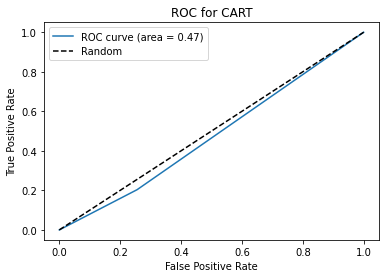

In [12]:
# Plot the ROC curve

def plot_roc(Y_test,Y_pred, name):
    fpr, tpr, _ = roc_curve(Y_test,Y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC for " + name)
    plt.legend(loc="best")
    plt.show()
plot_roc(Y_test,prediction, 'CART')

In [13]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model_random = RandomForestClassifier(random_state=42)
param_grid = {
             'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
              'min_samples_leaf':[1,2,4,6],
             'max_leaf_nodes':[10,50]}  
random_grid =  GridSearchCV(model_random,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
random_grid.fit(X_train,Y_train)
model_random = random_grid.best_estimator_
tree_error_rate =1 - model_random.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 736 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 6436 tasks      | elapsed:   11.8s
[Parallel(n_jobs=6)]: Done 7680 out of 7680 | elapsed:   14.1s finished


0.48453608247422686

In [14]:
model_random.score(X_train, Y_train)

0.9434782608695652

In [15]:
new_prediction = model_random.predict(X_test)
print(confusion_matrix(Y_test, new_prediction))

[[27 16]
 [31 23]]


In [16]:
print(classification_report(Y_test, new_prediction))

              precision    recall  f1-score   support

           0       0.47      0.63      0.53        43
           1       0.59      0.43      0.49        54

    accuracy                           0.52        97
   macro avg       0.53      0.53      0.51        97
weighted avg       0.53      0.52      0.51        97



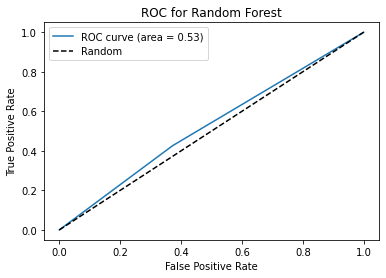

In [17]:
plot_roc(Y_test,new_prediction, "Random Forest")

In [18]:
# linear svm
from sklearn.svm import LinearSVC
model_svm = LinearSVC(random_state=42)
param_grid = {
             'C': [1,2,4,6,8,10],
             'loss':["hinge","squared_hinge"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None]}  
svm_grid =  GridSearchCV(model_svm,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
svm_grid.fit(X_train,Y_train)
model_svm = svm_grid.best_estimator_
svm_error_rate =1 - model_svm.score(X_test,Y_test)
svm_error_rate

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 480 out of 480 | elapsed:    1.2s finished


0.09278350515463918

In [19]:
model_svm.score(X_train, Y_train)

0.9956521739130435

In [20]:
svm_prediction = model_svm.predict(X_test)
print(confusion_matrix(Y_test, svm_prediction))

[[41  2]
 [ 7 47]]


In [21]:
print(classification_report(Y_test, svm_prediction))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90        43
           1       0.96      0.87      0.91        54

    accuracy                           0.91        97
   macro avg       0.91      0.91      0.91        97
weighted avg       0.91      0.91      0.91        97



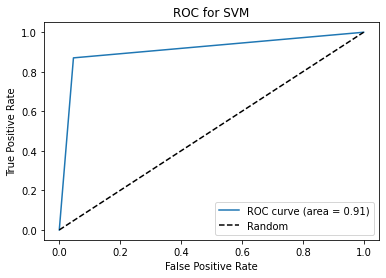

In [22]:
plot_roc(Y_test,svm_prediction, "SVM")

In [23]:
# logistic regression
from sklearn.linear_model import LogisticRegression
model_regression = LogisticRegression()
param_grid = {
             'C': [1,2,4,6,8,10],
             'penalty':["l1", "l2"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None],
              'warm_start':[True,False]}  
regression_grid =  GridSearchCV(model_regression,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
regression_grid.fit(X_train,Y_train)
model_regresssion= regression_grid.best_estimator_
regression_error_rate =1 - model_regresssion.score(X_test,Y_test)
regression_error_rate

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 960 out of 960 | elapsed:    4.7s finished


0.04123711340206182

In [24]:
regression_prediction = model_regresssion.predict(X_test)
print(confusion_matrix(Y_test, regression_prediction))

[[43  0]
 [ 4 50]]


In [25]:
print(classification_report(Y_test, regression_prediction))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96        43
           1       1.00      0.93      0.96        54

    accuracy                           0.96        97
   macro avg       0.96      0.96      0.96        97
weighted avg       0.96      0.96      0.96        97



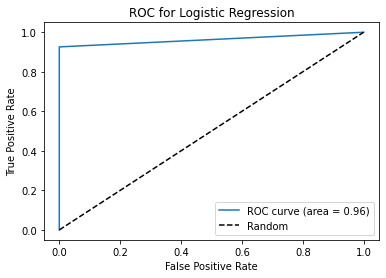

In [26]:
plot_roc(Y_test,regression_prediction, "Logistic Regression")

In [27]:
# install tensorflow in virtual enviroment locally or use google colab
# Please read this line at least.Basic model frame tuning may needed. I reached 0.7347 test accuracy for old dataset.
import tensorflow as tf
# Nerual network layer by layer. The input shape(...,62) may vary if new added
NN_model = tf.keras.models.Sequential()
NN_model.add(tf.keras.layers.Dense(units=128,activation="relu",input_dim=X_train.shape[1])) 
# dropout exist for preventing overfitting. 
NN_model.add(tf.keras.layers.Dropout(0.2))
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu"))
NN_model.add(tf.keras.layers.Dropout(0.2)) 
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu")) 
# please do not change this line. sigmoid function is a must for binary classification
NN_model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
# you can play with this line
NN_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy']) 

In [28]:
# a basic summary of model
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               8448      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 107,521
Trainable params: 107,521
Non-trainable params: 0
__________________________________________________

In [29]:
# I added early stop here.
earlyStopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
NN_model.fit(x=X_train,y=Y_train,batch_size=30,epochs=50,callbacks=[earlyStopping])

Train on 230 samples
Epoch 1/50
230/230 [==============================] - 1s 6ms/sample - loss: 0.7043 - accuracy: 0.5435
Epoch 2/50
230/230 [==============================] - 0s 792us/sample - loss: 0.6732 - accuracy: 0.5870
Epoch 3/50
230/230 [==============================] - 0s 1ms/sample - loss: 0.6560 - accuracy: 0.6130
Epoch 4/50
230/230 [==============================] - 0s 614us/sample - loss: 0.6537 - accuracy: 0.6261
Epoch 5/50
230/230 [==============================] - 0s 1ms/sample - loss: 0.6267 - accuracy: 0.6652
Epoch 6/50
230/230 [==============================] - 0s 510us/sample - loss: 0.6397 - accuracy: 0.6609
Epoch 7/50
230/230 [==============================] - 0s 871us/sample - loss: 0.6295 - accuracy: 0.6565
Epoch 8/50
230/230 [==============================] - 0s 711us/sample - loss: 0.6186 - accuracy: 0.6391
Epoch 9/50
230/230 [==============================] - 0s 623us/sample - loss: 0.6292 - accuracy: 0.6652
Epoch 10/50
230/230 [============================

In [30]:
test_loss, test_accuracy = NN_model.evaluate(X_test, Y_test)

97/97 [==============================] - 0s 1ms/sample - loss: 0.6496 - accuracy: 0.6495


In [31]:
NN_prediction = NN_model.predict_classes(X_test)
print(confusion_matrix(Y_test,NN_prediction))

[[25 18]
 [16 38]]


In [32]:
print(classification_report(Y_test,NN_prediction))

              precision    recall  f1-score   support

           0       0.61      0.58      0.60        43
           1       0.68      0.70      0.69        54

    accuracy                           0.65        97
   macro avg       0.64      0.64      0.64        97
weighted avg       0.65      0.65      0.65        97



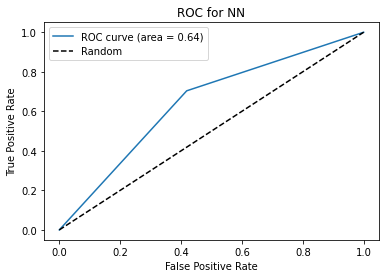

In [33]:
plot_roc(Y_test,NN_prediction, 'NN')

### Backtesting

In [64]:
portfolio_value = 100
portfolio_value_history = []
for i in range(0, len(btc) - LOOK_BACK_DAYS - LOOK_AHEAD_DAYS - 1):
    portfolio_value_history.append(portfolio_value)
    train_df = btc[i: i + LOOK_BACK_DAYS]
    X_TRAIN = train_df.drop(['MonthTrend'], axis=1)
    Y_TRAIN = le.fit_transform(train_df['MonthTrend'])
    test_df = btc[i + LOOK_BACK_DAYS + LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + LOOK_AHEAD_DAYS + 1]
    X_TEST = test_df.drop(['MonthTrend'], axis=1)
    results_df = btc[i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS + 1]
    
    model_regression = LogisticRegression()
    param_grid = {'C': [1,2,4]}  #simplified the CV so it runs faster
    regression_grid =  GridSearchCV(model_regression, param_grid, cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
    regression_grid.fit(X_TRAIN,Y_TRAIN)
    model_regresssion= regression_grid.best_estimator_
    
    prediction = model_regresssion.predict(X_TEST)[0]
    if prediction == 1:
        gains = ((results_df['Close'] - results_df['Open']) / results_df['Open'])[0]
        if gains > 0:
            print("GAIN! " + str(1 + gains))
        elif gains < 0:
            print("LOSS! " + str(1 + gains))
        portfolio_value = portfolio_value * (1 + gains)
    print("portfolio value: " + str(portfolio_value))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.8s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9842331661233105
portfolio value: 98.42331661233105
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0018506645601595
portfolio value: 98.60546515627884
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0280415609527733
portfolio value: 101.3705163177352
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0022620313782649
portfolio value: 101.59981960647683
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9799598258266199
portfolio value: 99.56374152557903
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 99.56374152557903
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 99.56374152557903
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 99.56374152557903
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0666155602568346
portfolio value: 106.19623594857215
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0335444319379241
portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.75852835741276
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9925127480608039
portfolio value: 108.9367386031254
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0021428022555043
portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.17016849231148
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9882157801978252
portfolio value: 107.88368323095762
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.88368323095762
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.88368323095762
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.88368323095762
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.88368323095762
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9880809570698097
portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.59781297906078
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0430394464188195
portfolio value: 111.1857238391364
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9902194357285534
portfolio value: 110.09826472106042
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0394438687204568
portfolio value: 114.44096622106802
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 114.44096622106802
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9805426310097526
portfolio value: 112.21424611370426
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 112.21424611370426
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 112.21424611370426
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 112.21424611370426
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0268936188890219
portfolio value: 115.23209328260513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 115.23209328260513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 115.23209328260513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 115.23209328260513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9787225139842252
portfolio value: 112.78024402921604
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9839107086642968
portfolio value: 110.96568982611828
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9917866038777885
portfolio value: 110.05428465960192
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0036575395972402
portfolio value: 110.45681256359036
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.45681256359036
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.45681256359036
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.45681256359036
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9690812085318505
portfolio value: 107.04162140970024
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9580454394380576
portfolio value: 102.55073722161846
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.55073722161846
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.55073722161846
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0014121515478125
portfolio value: 102.69555440391528
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.69555440391528
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.69555440391528
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.69555440391528
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9956677812083113
portfolio value: 102.25065479330375
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.25065479330375
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.25065479330375
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.25065479330375
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.25065479330375
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.014349607801453
portfolio value: 103.7179115870294
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9828472843381522
portfolio value: 101.93886774053642
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.986175791690628
portfolio value: 100.52964359806973
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100.52964359806973
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9698605332244129
portfolio value: 97.4997337448841
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 97.4997337448841
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 97.4997337448841
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0001168245467282
portfolio value: 97.51112410708497
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 97.51112410708497
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 97.51112410708497
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9899444496425026
portfolio value: 96.53059608821
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9748555841151165
portfolio value: 94.10339063455234
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 94.10339063455234
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9847279582693808
portfolio value: 92.6662397257887
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0198216400074884
portfolio value: 94.5030365704809
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9944348100446602
portfolio value: 93.97710922060975
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0843676681862628
portfolio value: 101.90573878843833
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9979226862622207
portfolio value: 101.69404859729455
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9899352624966742
portfolio value: 100.67052469251233
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100.67052469251233
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0017470941473823
portfolio value: 100.84640557701653
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9736955059174054
portfolio value: 98.19369189826496
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 98.19369189826496
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 98.19369189826496
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9927569266809558
portfolio value: 97.48246778837819
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9684200200112814
portfolio value: 94.4039734063703
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 94.4039734063703
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 94.4039734063703
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 94.4039734063703
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 94.4039734063703
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.050049279975456
portfolio value: 99.12882430218121
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 99.12882430218121
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0207144931952605
portfolio value: 101.18222765864293
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.18222765864293
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.004977081019406
portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.68581980342398
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0071910763540914
portfolio value: 102.41705029775879
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0073571235400032
portfolio value: 103.17054518940212
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.025626723407693
portfolio value: 105.81446821479182
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9744009967627031
portfolio value: 103.10572330040851
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0357496552119791
portfolio value: 106.79171735877985
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.79171735877985
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9893857546196765
portfolio value: 105.6582038661476
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 105.6582038661476
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 105.6582038661476
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 105.6582038661476
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 105.6582038661476
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0465127340076705
portfolio value: 110.57265579830195
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.57265579830195
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9978347798052194
portfolio value: 110.33324165097694
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.33324165097694
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9974684008769168
portfolio value: 110.05392211316641
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.027029769268814
portfolio value: 113.02865423501332
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 113.02865423501332
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.967920692457632
portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.40277327470835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0048728575626913
portfolio value: 109.93587740583942
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9767972207968315
portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.38505951588513
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0367709261874887
portfolio value: 111.33370761298282
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 111.33370761298282
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 111.33370761298282
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 111.33370761298282
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.180305294438141
portfolio value: 131.40776454503157
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0011506637707783
portfolio value: 131.5589706988925
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9965431396348158
portfolio value: 131.10418970739906
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 131.10418970739906
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 131.10418970739906
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 131.10418970739906
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9914443935942692
portfolio value: 129.98251386212027
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 129.98251386212027
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 129.98251386212027
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9652000583468278
portfolio value: 125.45912996378583
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9481906825551857
portfolio value: 118.95917807314183
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0012499732343842
portfolio value: 119.10787386171761
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 119.10787386171761
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0282812878999854
portfolio value: 122.47639793355599
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9905832655942777
portfolio value: 121.32307022324613
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0191655082300208
portfolio value: 123.64828852410115
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9895944900688941
portfolio value: 122.36166502989937
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0712622121567903
portfolio value: 131.08142796311816
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 131.08142796311816
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0215641903665413
portfolio value: 133.9080928292329
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9951107770714369
portfolio value: 133.25338631145206
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 133.25338631145206
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9987830368591373
portfolio value: 133.0912218519159
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.016480432667871
portfolio value: 135.28462277233106
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 135.28462277233106
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9998752055024313
portfolio value: 135.26773999580342
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 135.26773999580342
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0717345666984077
portfolio value: 144.97111271267525
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 144.97111271267525
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0233173629517578
portfolio value: 148.3514567653169
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9901531024549559
portfolio value: 146.89065516989078
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9575733401219685
portfolio value: 140.6585753037366
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 140.6585753037366
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 140.6585753037366
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.043309254009497
portfolio value: 146.7503932701801
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0157003479230886
portfolio value: 149.054425502372
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0025764080564745
portfolio value: 149.43845052508948
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0144948494370194
portfolio value: 151.60453836555212
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 151.60453836555212
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 151.60453836555212
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.1273680433386057
portfolio value: 170.91411177842508
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9841871527151077
portfolio value: 168.21147303003983
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0221364228899927
portfolio value: 171.93507333198139
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0134782146716854
portfolio value: 174.2524511599418
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9904108184812606
portfolio value: 172.58151277568385
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 172.58151277568385
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 172.58151277568385
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0290116028197172
portfolio value: 177.58837907835792
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.074458089739114
portfolio value: 190.8112705443981
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9905903212205259
portfolio value: 189.015797781072
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9748996932447151
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2714432751722
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.000203001592388
portfolio value: 184.3088506715887
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9791937471589017
portfolio value: 180.4740741236634
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9536920566169427
portfolio value: 172.1166909170351
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 172.1166909170351
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 172.1166909170351
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9542008175650334
portfolio value: 164.23388718962306
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0137520681953733
portfolio value: 166.492442806246
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9916344930451488
portfolio value: 165.09964911802018
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0388844527828014
portfolio value: 171.5194586286069
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0371048114569272
portfolio value: 177.8836558022156
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9906351683031609
portfolio value: 176.2178053040094
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0277044581896255
portfolio value: 181.0998241233219
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 181.0998241233219
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0743546514339681
portfolio value: 194.56543842076442
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9376983602682263
portfolio value: 182.44369257201936
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0128970124775534
portfolio value: 184.79667115157162
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.79667115157162
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9862571784482186
portfolio value: 182.25704347657233
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9988386217772866
portfolio value: 182.0453741153425
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0109654591577366
portfolio value: 184.04158523005916
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0011706666946827
portfolio value: 184.2570365843246
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 184.2570365843246
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 184.2570365843246
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9444485780096092
portfolio value: 174.0212961903299
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.017182559759993
portfolio value: 177.0114275116317
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 177.0114275116317
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9904230956881571
portfolio value: 175.31620600825008
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0068897027457264
portfolio value: 176.52408255415546
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0088592606946538
portfolio value: 178.08795542038732
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 178.08795542038732
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 178.08795542038732
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9870062092283622
portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 175.77391778870606
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9866452943655268
portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 173.4265088584198
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0333550111628982
portfolio value: 179.21115199733484
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 179.21115199733484
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0189465158811635
portfolio value: 182.60657893473393
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 182.60657893473393
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0005877262208878
portfolio value: 182.7139016092805
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 182.7139016092805
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0038356349679378
portfolio value: 183.4147254394214
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9963792090365983
portfolio value: 182.75061905899554
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.000488244088642
portfolio value: 182.83984596844675
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 182.83984596844675
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9934994498856212
portfolio value: 181.65128638682356
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 181.65128638682356
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0008585168499806
portfolio value: 181.8072370770073
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.003036853640908
portfolio value: 182.35935904686804
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 182.35935904686804
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 182.35935904686804
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0160300714098067
portfolio value: 185.2825925946359
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0056607392141264
portfolio value: 186.33142903223134
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 186.33142903223134
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.014427186018474
portfolio value: 189.0196672199674
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 189.0196672199674
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.1096043820812165
portfolio value: 209.73705104680909
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 209.73705104680909
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0171827594501375
portfolio value: 213.34091234272762
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0010253180716313
portfolio value: 213.55965463557092
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 213.55965463557092
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 213.55965463557092
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9400319326300404
portfolio value: 200.7528948788797
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0183433831596385
portfolio value: 204.4353821500496
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0484833799148676
portfolio value: 214.3471004508716
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


GAIN! 1.0025449082386875
portfolio value: 214.8925941527478
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9849373067625922
portfolio value: 211.65573292803418
Fitting 10 folds for each of 3 candidates, totalling 30 fits
GAIN! 1.0128822004898905
portfolio value: 214.38232451444784
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9947529836248726
portfolio value: 213.25745694718267


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

base_portfolio_value = 100
base_portfolio_value_history = []
for i in range(0, len(btc) - LOOK_BACK_DAYS - LOOK_AHEAD_DAYS - 1):
    base_portfolio_value_history.append(base_portfolio_value)
    train_df = btc[i: i + LOOK_BACK_DAYS]
    X_TRAIN = train_df['Open']
    results_df = btc[i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS + 1]
    
    model = ARIMA(list(X_TRAIN), order=(5,1,0))
    
    try:
        model_fit = model.fit(disp=0)
        prediction = model_fit.forecast()[0]
    except:
        continue
    print(prediction)
    if prediction >= train_df.tail(1)['Open'][0]:
        gains = ((results_df['Close'] - results_df['Open']) / results_df['Open'])[0]
        if gains > 0:
            print("GAIN! " + str(1 + gains))
        elif gains < 0:
            print("LOSS! " + str(1 + gains))
        base_portfolio_value = base_portfolio_value * (1 + gains)
    print("portfolio value: " + str(base_portfolio_value))


[8288.10099145]
portfolio value: 100
[8372.54046896]
portfolio value: 100
[8105.08301573]
portfolio value: 100
[7942.99905768]
portfolio value: 100
[8021.14529826]
portfolio value: 100
[7965.39330177]
portfolio value: 100
[7902.59793595]
portfolio value: 100
[8182.21830061]
portfolio value: 100
[8366.46023379]
GAIN! 1.1561932238921162
portfolio value: 115.61932238921162
[7923.60819907]
portfolio value: 115.61932238921162
[7444.46929358]
portfolio value: 115.61932238921162
[7625.38614158]
LOSS! 0.9676999639803877
portfolio value: 111.88481411147691
[8600.08956281]
portfolio value: 111.88481411147691
[9918.14289243]
GAIN! 1.0070125367827818
portfolio value: 112.66941048586835
[9283.21183322]
LOSS! 0.9904091518510287
portfolio value: 111.58881527886427
[9189.31040556]
portfolio value: 111.58881527886427
[9419.00949393]
LOSS! 0.9925127480608039
portfolio value: 110.753321705275
[9370.4820007]
GAIN! 1.0021428022555043
portfolio value: 110.99064417282966
[9236.27756748]
LOSS! 0.9909293775166

In [ ]:
always_buy_portfolio_value = 100
always_buy_portfolio_value_history = []
for i in range(0, len(btc) - LOOK_BACK_DAYS - LOOK_AHEAD_DAYS - 1):
    results_df = btc[i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS + 1]
    always_buy_portfolio_value_history.append(always_buy_portfolio_value)
   
    gains = ((results_df['Close'] - results_df['Open']) / results_df['Open'])[0]
    if gains > 0:
        print("GAIN! " + str(1 + gains))
    elif gains < 0:
        print("LOSS! " + str(1 + gains))
    always_buy_portfolio_value = always_buy_portfolio_value * (1 + gains)
    print("portfolio value: " + str(always_buy_portfolio_value))


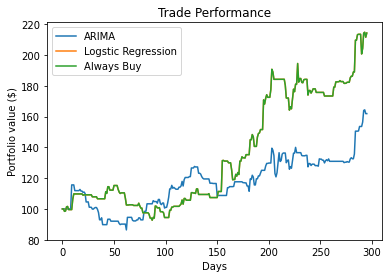

In [63]:

plt.plot(range(0, len(base_portfolio_value_history)), base_portfolio_value_history, label='ARIMA')    
plt.plot(range(0, len(portfolio_value_history)), portfolio_value_history, label='Logstic Regression')
plt.plot(range(0, len(always_buy_portfolio_value_history)), portfolio_value_history, label='Always Buy')

plt.xlabel('Days')
plt.ylabel('Portfolio value ($)')
plt.title("Trade Performance")
plt.legend(["ARIMA", "Logstic Regression", "Always Buy"])
plt.show()